In [1]:
# Model Building
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.pipeline import make_pipeline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# For running this notebook either locally or in colab
import sys

In [2]:
#This line below just captures all the output for the cell, so we don't have to look at it
%%capture
# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Applied-Modeling/master/data/'
    !pip install category_encoders==2.*

# If you're working locally:
else:
    DATA_PATH = '../data/'

In [3]:
# For encoding categorical data
from category_encoders import OneHotEncoder

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# NYC Rent

**GOAL:** Improve our model for predicting NYC rent prices.

**Objectives**

- Do one-hot encoding of categorical features
- Do univariate feature selection
- Use scikit-learn to fit Ridge Regression models

# I. Wrangle Data

Create **wrangle function** for **reproducibility**.

In [4]:
def wrangle(filepath):
  df = pd.read_csv(filepath,
                   parse_dates=['created'],
                   index_col='created').sort_index() #read in already sorted by dates (which are now the index)
  
  # Remove outlier observations
  df = df[(df['price'] >= np.percentile(df['price'], 0.5)) & 
          (df['price'] <= np.percentile(df['price'], 99.5)) & 
          (df['latitude'] >= np.percentile(df['latitude'], 0.05)) & 
          (df['latitude'] < np.percentile(df['latitude'], 99.95)) &
          (df['longitude'] >= np.percentile(df['longitude'], 0.05)) & 
          (df['longitude'] <= np.percentile(df['longitude'], 99.95))]

  # Drop High-Cardinality Columns
  threshold = 10

  #1) WHAT WE DID BEFORE
  # cols_to_drop = []
  # for col in df:
  #   if df[col].dtype == 'object':
  #     if df[col].nunique() > threshold:
  #       cols_to_drop.append(col)

  #2) REWRITTEN VIA LIST COMPREHENSION
  drop_cols = [col for col in df.select_dtypes('object').columns
               if df[col].nunique() > threshold]

  df = df.drop(columns=drop_cols)

  #ONE-HOT / DUMMIES
  new_columns = pd.get_dummies(df['interest_level'])
  new_columns.columns=['High_Interest', 'Low_Interest', 'Med_Interest']
  df = df.drop(columns=['interest_level']).join(new_columns, how='outer')

  return df

df = wrangle(DATA_PATH+'apartments/renthop-nyc.csv')

In [5]:
# print(list(df.columns)); print()

# print(df.isnull().sum()); print()

# print(df.info())

# II. Split Data

Split **target vector** from **feature matrix**.

In [6]:
target = 'price'
y = df[target]
X = df.drop(columns=target)

Split data into **training** and **test** sets.

(Use data from April & May 2016 to train. Use data from June 2016 to test.)

In [7]:
#1) METHOD 1
mask = ( (df.index.month == 4) | (df.index.month == 5) )

X_train, y_train = X[mask], y[mask]
X_test, y_test = X[~mask], y[~mask]

In [8]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(32676, 31) (32676,)
(17509, 31) (17509,)


In [9]:
#2) METHOD 2
cutoff = '2016-06-01'
mask = X.index < cutoff

X_train, y_train = X.loc[mask], y.loc[mask]
X_test, y_test = X.loc[~mask], y.loc[~mask]

In [10]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(32676, 31) (32676,)
(17509, 31) (17509,)


# III. Establish Baseline

**Note:** This is a **regression** problem because we're predictiong the continuous value `'price'`.

In [11]:
y_pred = [y_train.mean()] * len(y_train)
print('Mean Price:', y_train.mean())
print('Baseline MAE:', mean_absolute_error(y_train, y_pred) )

Mean Price: 3573.460705104664
Baseline MAE: 1201.2534014392165


# IV. Build Models

**Question:** How can we represent *categorical* features numerically so that we can use them to train our model?

**ORDINAL ENCODING**: using integers to represent classes (this will approximately work for our model but is in general bad practice because Medium + Medium is being treated as equal to High)

**ONE-HOT ENCODING**: create additional binary columns in which only one will be on (=1) in each row

In [12]:
#OHE METHOD 1 (already applied)
df[ ['High_Interest', 'Low_Interest', 'Med_Interest'] ].head()

#OHE METHOD 2
ohe = OneHotEncoder(use_cat_names=True)
ohe.fit(X_train) #Just like a model, it looks through and parses features to find out which need to be encoded
XT_train = ohe.transform(X_train) #The convention is to name the transformed object XT_train
#any other transformations become XT2_train, XT3_train, etc...
#note that you also have to transform the X_test independent variables as well!
XT_test = ohe.transform(X_test)

#No, you don't need to transform the y_train or y_test vectors -- they don't have the categorical variables

**To avoid confusing multiple transformations, we create a pipeline**

* e.g. input = [X][y] --> T1 (OHE) --> T2 (imputer) --> P (linear regression)

* Always put transformers at the beginning, and predictor at the end

* Transformations will be done in the order they are provided, left to right

* Can have any number of transformers, but only one predictor

**Note that pipelines don't allow model.coef_ to get coefficients**


In [39]:
#THIS IS HOW TO MAKE A PIPELINE (replaces most of the code above and below)

#LINEAR REGRESSION PIPELINE*****************************************************
from sklearn.pipeline import make_pipeline
model_lr = make_pipeline(
    OneHotEncoder(use_cat_names=True),
    LinearRegression()
)
model_lr.fit(X_train, y_train)
#LINEAR REGRESSION PREDICTIONS
print("Predictions:", model_lr.predict(X_test))
print("Coefficients:", model_lr.named_steps['linearregression'].coef_)
print("Features:", model_lr.named_steps['onehotencoder'].get_feature_names())
print('LR Training MAE:', mean_absolute_error(y_train, model_lr.predict(X_train)))
print('LR Testing MAE:', mean_absolute_error(y_test, model_lr.predict(X_test)))
print()

#RIDGE REGRESSION PIPELINE******************************************************
from sklearn.pipeline import make_pipeline
model_r = make_pipeline(
    OneHotEncoder(use_cat_names=True),
    Ridge(alpha=1.0)
)
model_r.fit(X_train, y_train)
#RIDGE REGRESSION PREDICTIONS
print("Predictions:", model_r.predict(X_test))
print("Coefficients:", model_r.named_steps['ridge'].coef_)
print("Features:", model_r.named_steps['onehotencoder'].get_feature_names())
print('LR Training MAE:', mean_absolute_error(y_train, model_r.predict(X_train)))
print('LR Testing MAE:', mean_absolute_error(y_test, model_r.predict(X_test)))

Predictions: [2394.5669558  2379.36294238 3503.88230155 ... 3228.07644843 3110.62727649
 3069.93903583]
Coefficients: [  1704.06029868    492.01171868   1192.33509572 -13104.38129289
    150.6901404     -28.91727116   -146.01296156     69.60551183
    425.33938785     55.15307772   -104.29750212   -111.52249688
    124.43970311    -91.95188103    477.14708504   -163.90032511
    -84.84903395    259.83249345   -298.07381866    -46.710564
     60.61872243   -132.93453999    169.98563519    140.11389659
    129.72922157    -36.27501579    156.97227869   -147.04115883
   -306.24086751    401.0787163     -94.83784878]
Features: ['bathrooms', 'bedrooms', 'latitude', 'longitude', 'elevator', 'cats_allowed', 'hardwood_floors', 'dogs_allowed', 'doorman', 'dishwasher', 'no_fee', 'laundry_in_building', 'fitness_center', 'pre-war', 'laundry_in_unit', 'roof_deck', 'outdoor_space', 'dining_room', 'high_speed_internet', 'balcony', 'swimming_pool', 'new_construction', 'terrace', 'exclusive', 'loft', '

**Model 1:** Regular ol' linear regression

In [13]:
# model_lr = LinearRegression()
# model_lr.fit(X_train, y_train)

LinearRegression()

**Model 2:** Ridge regression (regularization)

**RIDGE IS USEFUL WHEN YOU HAVE TOO MANY COLUMNS**

$RSS = \sum{(y-\hat{y})^2} + \alpha \sum{\beta_i^2}$

$RSS = \sum{(y-(\beta_0 + \beta_1 x_1 + ... + \beta_n x_n))^2} + \alpha \sum{\beta_i^2}$

We add a new ridge penalty term for the model to minimize

This alpha is called a hyper parameter

In [14]:
# model_r = Ridge(alpha=1.0)
# model_r.fit(X_train, y_train)

Ridge()

**Model 3:** `SelectKBest`

In [15]:
model_lr_skb = ...

# V. Check Metrics

In [16]:
# print('LR Training MAE:', mean_absolute_error(y_train, model_lr.predict(X_train)))
# print('LR Testing MAE:', mean_absolute_error(y_test, model_lr.predict(X_test)))

LR Training MAE: 674.4866555892306
LR Testing MAE: 678.7700861828881


In [17]:
# print('Ridge Training MAE:', mean_absolute_error(y_train, model_r.predict(X_train)))
# print('Ridge Testing MAE:', mean_absolute_error(y_test, model_r.predict(X_test)))

Ridge Training MAE: 674.0157349767211
Ridge Testing MAE: 678.2221039842412


# VI. Tune Model

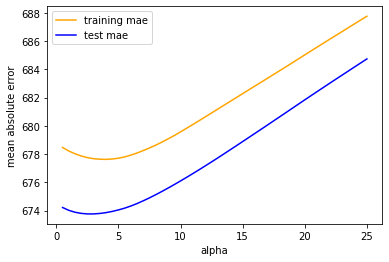

In [40]:
#RIDGE HYPERPARAMETER LOOP
alphas = np.linspace(0.5,25,num=50)
train_mae = []
test_mae = []

for a in alphas:
  model_r = make_pipeline(
      OneHotEncoder(use_cat_names=True),
      Ridge(alpha=a)
  )
  model_r.fit(X_train, y_train)
  test_mae.append(mean_absolute_error(y_train, model_r.predict(X_train)))
  train_mae.append(mean_absolute_error(y_test, model_r.predict(X_test)))

plt.plot(alphas, train_mae, color='orange', label='training mae')
plt.plot(alphas, test_mae, color='blue', label='test mae')
plt.xlabel('alpha')
plt.ylabel('mean absolute error')
plt.legend();

#IT IS CHEATING TO LOOK AT THE TEST SET
# SO WE USE ANOTHER SPLIT WITH A VALIDATION SET TO TUNE THE HYPERPARAMETERS

#Usually ~ 60 20 20 (training should always be largest)
# Larger data sets allow for smaller test and validation sets  

# Communicate results

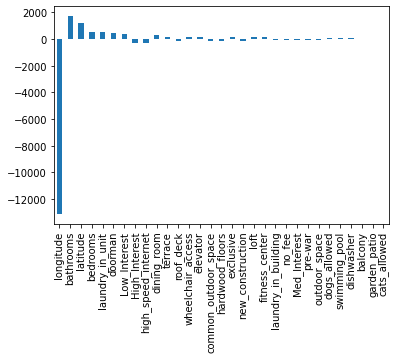

In [41]:
coefficients = model_lr.named_steps['linearregression'].coef_
#features = list(X.columns) #features = ohe.get_feature_names()
features = model_lr.named_steps['onehotencoder'].get_feature_names()
important_features = pd.Series(coefficients, index=features).sort_values(key=abs, ascending=False)

#When some variables are dominating, the beta coefficients needs to be regularized
# to ensure that they are not causing overfitting

#It is common with high-dimensionality that overfitting will occur by relying too
# heavily on a small subset of your variables

important_features.plot(kind='bar');

#print(important_features); print()

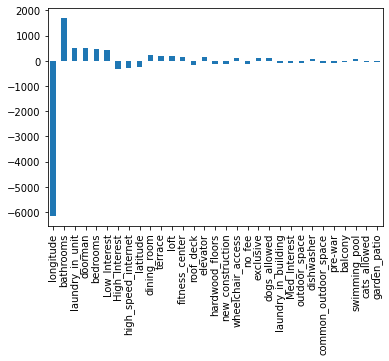

In [42]:
coefficients = model_r.named_steps['ridge'].coef_
#features = list(X.columns) #features = ohe.get_feature_names()
features = model_r.named_steps['onehotencoder'].get_feature_names()
important_features = pd.Series(coefficients, index=features).sort_values(key=abs, ascending=False)
important_features.plot(kind='bar');